In [1]:
%run supervised_functions.ipynb

Calculating probability for start mol sampling


100%|█████████████████████████████████████████████████████████| 69304/69304 [01:45<00:00, 656.85it/s]


# Generate data

In [2]:
np.random.seed(42)

N = 100000
steps = 5

# generate data
train_df = generate_train_data(int(N*0.8), steps)
test_df = generate_train_data(int(N*0.2), steps)
print(train_df.shape, test_df.shape)

# Randomize and concat 
main_df = pd.concat([train_df.sample(frac=1), test_df.sample(frac=1)])
print(main_df.shape)

Creating dataset...


83869it [04:42, 297.30it/s]                                                                          


Creating dataset...


23327it [01:14, 313.56it/s]                                                                          


(83869, 10) (23327, 10)
(107196, 10)


# Load/build stuff

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

#### Action embedings

In [4]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

#### Indices (for faster access)

In [5]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

100%|███████████████████████████████████████████████████████| 107196/107196 [05:52<00:00, 303.93it/s]


# Training

In [6]:
train_idx = np.arange(0, int(main_df.shape[0]*0.8))
test_idx = np.arange(int(main_df.shape[0]*0.8), main_df.shape[0])

train_idx = torch.arange(0, int(main_df.shape[0]*0.8))[:500]
test_idx = torch.arange(int(main_df.shape[0]*0.8), main_df.shape[0])[-200:]

In [7]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)
train_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["rsig"]))).to(device)
train_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["psig"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["rsig"]))).to(device)
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["psig"]))).to(device)

print(train_reactants.batch_size, train_products.batch_size, train_rsigs.batch_size, train_psigs.batch_size)
print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size)

85756 85756 85756 85756
21440 21440 21440 21440
CPU times: user 17min 36s, sys: 40.4 s, total: 18min 17s
Wall time: 17min 34s


100%|████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.30it/s]


Epoch 1/50. Batch 85504/85628. Actor loss = 11.243458 || critic loss = 0.023119

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  1 │ 4.3109 │  0.786216 │         266.506 │          509.6 │         652.19 │         257.611 │         497.14 │         652.19 │ 14.94 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.25it/s]


BEST MODEL UPDATED! BEST RANK = 266.50626871257487
Epoch 2/50. Batch 85504/85628. Actor loss = 11.246694 || critic loss = 0.016799

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  2 │ 4.4399 │  0.803536 │         279.493 │          521.9 │         652.19 │         271.848 │        519.771 │         652.19 │ 14.72 min               │
╘════╧════════╧═══════════╧═════════════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.09it/s]


Epoch 3/50. Batch 85504/85628. Actor loss = 11.190423 || critic loss = 0.015886

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  3 │ 4.46144 │  0.797299 │         280.306 │        521.428 │         652.19 │         271.201 │        517.488 │         652.19 │ 15.03 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.44it/s]


Epoch 4/50. Batch 85504/85628. Actor loss = 11.133120 || critic loss = 0.014083

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  4 │ 4.38748 │  0.795313 │         275.551 │         515.58 │         652.19 │         266.093 │        509.736 │         652.19 │ 11.44 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.45it/s]


Epoch 5/50. Batch 85504/85628. Actor loss = 11.035126 || critic loss = 0.015447

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  5 │ 4.30308 │  0.795068 │         269.162 │        507.344 │         652.19 │         258.889 │        501.483 │         652.19 │ 11.34 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.39it/s]


Epoch 6/50. Batch 85504/85628. Actor loss = 11.064934 || critic loss = 0.013865

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  6 │ 4.21532 │   0.79361 │         268.906 │        510.224 │         652.19 │          260.85 │        505.579 │         652.19 │ 11.31 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.22it/s]


Epoch 7/50. Batch 85504/85628. Actor loss = 11.021739 || critic loss = 0.015348

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  7 │ 4.13922 │  0.792393 │         265.843 │        507.882 │         652.19 │         257.594 │        503.747 │         652.19 │ 11.32 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.39it/s]


BEST MODEL UPDATED! BEST RANK = 265.842627245509
Epoch 8/50. Batch 85504/85628. Actor loss = 11.053188 || critic loss = 0.014166

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  8 │ 4.15076 │  0.787057 │         262.483 │         503.44 │         652.19 │         253.675 │        498.022 │         652.19 │ 11.32 min               │
╘════╧═════════╧═══════════╧═════════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.15it/s]


BEST MODEL UPDATED! BEST RANK = 262.48283121257487
Epoch 9/50. Batch 85504/85628. Actor loss = 11.012468 || critic loss = 0.015343

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  9 │ 4.09163 │  0.785662 │         261.385 │        500.112 │         652.19 │         251.808 │        494.539 │         652.19 │ 11.28 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.10it/s]


BEST MODEL UPDATED! BEST RANK = 261.38524513473055
Epoch 10/50. Batch 85504/85628. Actor loss = 11.010201 || critic loss = 0.013566

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 10 │ 4.03011 │  0.782589 │         262.675 │        504.097 │         652.19 │         252.847 │        499.982 │         652.19 │ 11.23 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.34it/s]


Epoch 11/50. Batch 85504/85628. Actor loss = 11.040924 || critic loss = 0.012795

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 11 │ 4.02115 │  0.781035 │         255.129 │        495.764 │         652.19 │         244.327 │        488.469 │         652.19 │ 11.19 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.44it/s]


BEST MODEL UPDATED! BEST RANK = 255.12888285928145
Epoch 12/50. Batch 85504/85628. Actor loss = 10.981500 || critic loss = 0.012555

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 12 │ 3.99341 │  0.775698 │         250.953 │        493.479 │         652.19 │          239.16 │        485.265 │         652.19 │ 11.41 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.22it/s]


BEST MODEL UPDATED! BEST RANK = 250.95251684131736
Epoch 13/50. Batch 85504/85628. Actor loss = 11.081920 || critic loss = 0.014065

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 13 │ 3.94508 │  0.774566 │         248.973 │        490.771 │         652.19 │         237.354 │        481.885 │         652.19 │ 11.26 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.21it/s]


BEST MODEL UPDATED! BEST RANK = 248.97333458083833
Epoch 14/50. Batch 85504/85628. Actor loss = 11.016289 || critic loss = 0.013819

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 14 │ 3.91606 │  0.772857 │         247.137 │        490.418 │         652.19 │         235.855 │        481.769 │         652.19 │ 11.23 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.14it/s]


BEST MODEL UPDATED! BEST RANK = 247.1373502994012
Epoch 15/50. Batch 85504/85628. Actor loss = 11.043985 || critic loss = 0.014214

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 15 │ 3.85684 │  0.769449 │         250.895 │         492.46 │         652.19 │         241.477 │        489.152 │         652.19 │ 11.92 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:09<00:00,  4.49it/s]


Epoch 16/50. Batch 85504/85628. Actor loss = 11.044574 || critic loss = 0.015718

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 16 │ 3.82891 │  0.768098 │         250.441 │        492.529 │         652.19 │         239.204 │        484.861 │         652.19 │ 12.01 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.38it/s]


Epoch 17/50. Batch 85504/85628. Actor loss = 11.011527 || critic loss = 0.013042

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 17 │ 3.83966 │  0.766865 │         245.379 │        487.252 │         652.19 │         235.268 │        479.968 │         652.19 │ 11.57 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.24it/s]


BEST MODEL UPDATED! BEST RANK = 245.3786489520958
Epoch 18/50. Batch 85504/85628. Actor loss = 11.097010 || critic loss = 0.014949

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 18 │ 3.78164 │  0.764486 │         246.542 │        487.547 │         652.19 │         235.351 │        479.612 │         652.19 │ 11.28 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.32it/s]


Epoch 19/50. Batch 85504/85628. Actor loss = 11.106032 || critic loss = 0.013426

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 19 │ 3.71993 │  0.764962 │         240.442 │        481.997 │         652.19 │         228.486 │         470.66 │         652.19 │ 11.17 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.30it/s]


BEST MODEL UPDATED! BEST RANK = 240.44161676646706
Epoch 20/50. Batch 85504/85628. Actor loss = 11.014858 || critic loss = 0.014975

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 20 │ 3.74096 │  0.763044 │         241.611 │        481.414 │         652.19 │         229.611 │        469.225 │         652.19 │ 11.18 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.52it/s]


Epoch 21/50. Batch 85504/85628. Actor loss = 11.038201 || critic loss = 0.011989

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 21 │ 3.7874 │  0.758954 │         239.719 │        480.864 │         652.19 │         226.967 │        467.223 │         652.19 │ 11.27 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.64it/s]


BEST MODEL UPDATED! BEST RANK = 239.71875
Epoch 22/50. Batch 85504/85628. Actor loss = 11.063725 || critic loss = 0.014356

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 22 │ 3.73752 │  0.754967 │         237.336 │        478.189 │         652.19 │         223.313 │        462.977 │         652.19 │ 11.20 min               │
╘════╧═════════╧═══════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.35it/s]


BEST MODEL UPDATED! BEST RANK = 237.33617140718562
Epoch 23/50. Batch 85504/85628. Actor loss = 11.027599 || critic loss = 0.011045

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 23 │ 3.7217 │  0.756128 │         235.691 │        477.061 │         652.19 │         221.121 │        460.002 │         652.19 │ 11.31 min               │
╘════╧════════╧═══════════╧═════════════════╧═

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.56it/s]


BEST MODEL UPDATED! BEST RANK = 235.6907747005988
Epoch 24/50. Batch 85504/85628. Actor loss = 11.022640 || critic loss = 0.012071

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 24 │ 3.71921 │  0.754864 │         235.064 │        476.608 │         652.19 │         221.158 │        461.015 │         652.19 │ 11.23 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.74it/s]


BEST MODEL UPDATED! BEST RANK = 235.06432447604791
Epoch 25/50. Batch 85504/85628. Actor loss = 11.081079 || critic loss = 0.012386

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 25 │ 3.65911 │  0.757068 │         232.828 │        475.303 │         652.19 │         218.746 │        457.826 │         652.19 │ 11.17 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.71it/s]


BEST MODEL UPDATED! BEST RANK = 232.82770396706587
Epoch 26/50. Batch 85504/85628. Actor loss = 11.092532 || critic loss = 0.014649

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 26 │ 3.69107 │  0.757565 │         236.033 │        478.973 │         652.19 │         221.969 │        462.212 │         652.19 │ 11.28 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.50it/s]


Epoch 27/50. Batch 85504/85628. Actor loss = 11.094122 || critic loss = 0.016685

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 27 │ 3.64653 │  0.755176 │         234.864 │        476.386 │         652.19 │         220.957 │        458.767 │         652.19 │ 11.25 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.25it/s]


Epoch 28/50. Batch 85504/85628. Actor loss = 11.120571 || critic loss = 0.016415

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 28 │ 3.60368 │   0.75651 │         233.104 │          472.1 │         652.19 │         219.519 │        455.796 │         652.19 │ 11.34 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.68it/s]


Epoch 29/50. Batch 85504/85628. Actor loss = 10.991483 || critic loss = 0.013771

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 29 │ 3.63197 │   0.75252 │         236.238 │        477.518 │         652.19 │         221.053 │        458.213 │         652.19 │ 11.19 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.05it/s]


Epoch 30/50. Batch 85504/85628. Actor loss = 11.053931 || critic loss = 0.018413

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 30 │ 3.61903 │  0.753234 │         229.718 │        470.489 │         652.19 │         214.063 │        450.501 │         652.19 │ 11.21 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.85it/s]


BEST MODEL UPDATED! BEST RANK = 229.71772080838323
Epoch 31/50. Batch 85504/85628. Actor loss = 11.103858 || critic loss = 0.014753

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 31 │ 3.66392 │  0.748643 │         230.057 │        470.727 │         652.19 │         215.906 │        452.912 │         652.19 │ 11.20 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.71it/s]


Epoch 32/50. Batch 85504/85628. Actor loss = 11.085273 || critic loss = 0.015854

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 32 │ 3.56881 │  0.747604 │         229.726 │        471.808 │         652.19 │         214.405 │        452.133 │         652.19 │ 11.24 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.55it/s]


Epoch 33/50. Batch 85504/85628. Actor loss = 11.069361 || critic loss = 0.014033

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 33 │ 3.5845 │  0.744835 │         226.052 │        466.489 │         652.19 │         212.644 │        447.842 │         652.19 │ 11.28 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


BEST MODEL UPDATED! BEST RANK = 226.05239520958085
Epoch 34/50. Batch 85504/85628. Actor loss = 11.093719 || critic loss = 0.018454

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 34 │ 3.5839 │  0.744896 │         228.195 │        468.903 │         652.19 │         214.681 │        452.672 │         652.19 │ 11.27 min               │
╘════╧════════╧═══════════╧═════════════════╧═

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.39it/s]


Epoch 35/50. Batch 85504/85628. Actor loss = 11.115032 || critic loss = 0.013966

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 35 │ 3.57378 │  0.744819 │         228.526 │        468.666 │         652.19 │         215.189 │        451.309 │         652.19 │ 11.20 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.22it/s]


Epoch 36/50. Batch 85504/85628. Actor loss = 11.129245 || critic loss = 0.014265

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 36 │ 3.5419 │  0.747008 │         225.484 │        465.128 │         652.19 │         210.623 │        443.786 │         652.19 │ 11.20 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.48it/s]


BEST MODEL UPDATED! BEST RANK = 225.48353293413174
Epoch 37/50. Batch 85504/85628. Actor loss = 11.124105 || critic loss = 0.018732

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 37 │ 3.50536 │  0.746149 │         228.439 │        469.693 │         652.19 │         214.397 │        450.061 │         652.19 │ 11.18 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.47it/s]


Epoch 38/50. Batch 85504/85628. Actor loss = 11.051798 || critic loss = 0.012590

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 38 │ 3.52191 │   0.74311 │          226.23 │        466.332 │         652.19 │         212.999 │        446.904 │         652.19 │ 11.27 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.33it/s]


Epoch 39/50. Batch 85504/85628. Actor loss = 11.091894 || critic loss = 0.013783

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 39 │ 3.49289 │  0.744791 │         227.366 │        467.961 │         652.19 │         214.969 │        449.812 │         652.19 │ 11.17 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.80it/s]


Epoch 40/50. Batch 85504/85628. Actor loss = 11.097225 || critic loss = 0.014786

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 40 │ 3.48225 │  0.745059 │         226.425 │        467.547 │         652.19 │         213.222 │        448.272 │         652.19 │ 11.27 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.75it/s]


Epoch 41/50. Batch 85504/85628. Actor loss = 11.054790 || critic loss = 0.016775

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 41 │ 3.48854 │  0.744446 │         226.333 │        468.044 │         652.19 │         213.386 │        450.684 │         652.19 │ 11.22 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.50it/s]


Epoch 42/50. Batch 85504/85628. Actor loss = 11.124871 || critic loss = 0.018267

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 42 │ 3.43232 │  0.744063 │         224.369 │        467.171 │         652.19 │         211.226 │        448.729 │         652.19 │ 11.12 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.51it/s]


BEST MODEL UPDATED! BEST RANK = 224.3691991017964
Epoch 43/50. Batch 85504/85628. Actor loss = 11.111660 || critic loss = 0.011844

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 43 │ 3.43212 │  0.742976 │         225.634 │        468.374 │         652.19 │         211.761 │        448.477 │         652.19 │ 11.13 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.65it/s]


Epoch 44/50. Batch 85504/85628. Actor loss = 11.103744 || critic loss = 0.014140

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 44 │ 3.44064 │  0.743086 │          222.16 │        465.013 │         652.19 │         210.434 │        447.944 │         652.19 │ 11.15 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.59it/s]


BEST MODEL UPDATED! BEST RANK = 222.16036676646706
Epoch 45/50. Batch 85504/85628. Actor loss = 11.136618 || critic loss = 0.016181

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 45 │ 3.46896 │  0.743531 │         223.019 │        464.402 │         652.19 │         210.774 │          447.8 │         652.19 │ 11.17 min               │
╘════╧═════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.60it/s]


Epoch 46/50. Batch 85504/85628. Actor loss = 11.121686 || critic loss = 0.016516

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 46 │ 3.47546 │  0.741741 │         224.191 │        468.295 │         652.19 │         211.707 │        451.272 │         652.19 │ 11.24 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.71it/s]


Epoch 47/50. Batch 85504/85628. Actor loss = 11.181188 || critic loss = 0.012472

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 47 │ 3.43116 │  0.743576 │         226.775 │        470.035 │         652.19 │         214.549 │        454.911 │         652.19 │ 11.27 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.35it/s]


Epoch 48/50. Batch 85504/85628. Actor loss = 11.168753 || critic loss = 0.015655

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 48 │ 3.41837 │  0.742948 │         225.242 │        468.472 │         652.19 │         212.626 │        451.025 │         652.19 │ 11.17 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.92it/s]


Epoch 49/50. Batch 85504/85628. Actor loss = 11.195914 || critic loss = 0.015611

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 49 │ 3.39362 │  0.741417 │         224.529 │        467.078 │         652.19 │         211.251 │        449.388 │         652.19 │ 11.21 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


Epoch 50/50. Batch 85504/85628. Actor loss = 11.184635 || critic loss = 0.013596

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 50 │ 3.44618 │  0.741056 │         224.433 │        467.788 │         652.19 │         210.201 │        447.572 │         652.19 │ 11.17 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.57it/s]


Saved model at models/supervised/offlineRL/emb_model_update=1||steps=5||topk=10


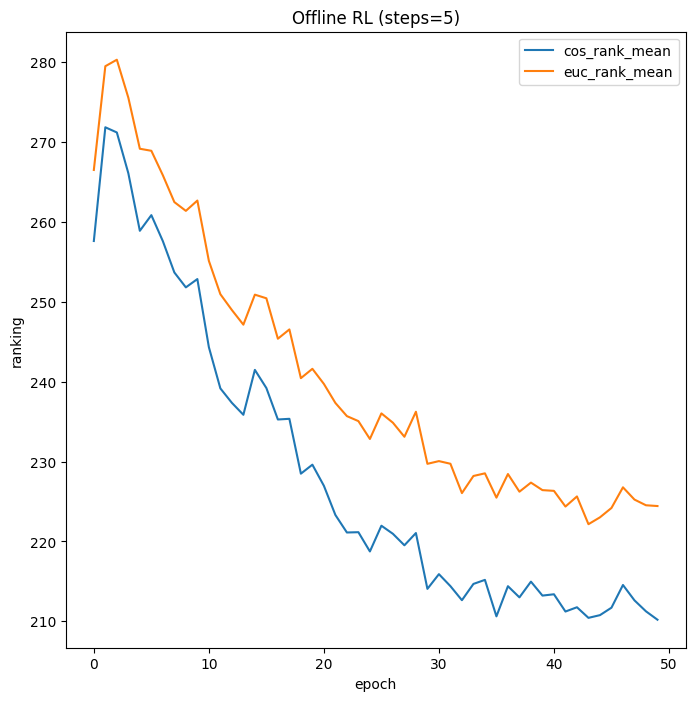

In [8]:
actor_lr = 3e-4
critic_lr = 1e-3
epochs = 50
batch_size = 128
distance_metric, topk, emb_model_update = "euclidean", 10, 1


# Model inits
model = ActorCritic().to(device)
actor_optimizer = torch.optim.Adam(model.parameters(), lr=actor_lr)  
critic_optimizer = torch.optim.Adam(model.parameters(), lr=critic_lr)  
critic_loss_criterion = nn.MSELoss()

# For actor log prob calc
actor_log_std = nn.Parameter(torch.zeros(model.actor.last_layer.out_features, dtype=torch.float32)).to(device)

# Embeddings init
embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
embedding_model.load_state_dict(model.GIN.state_dict())
action_embeddings = get_action_dataset_embeddings(embedding_model)
action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

# Some helper inits
best_rank = 10000
best_model = None
metric_dict = {"cos_rank_mean": [], "euc_rank_mean": [], "cos_rank_std": [], "euc_rank_std": [], 
               "cos_rank_tot": [], "euc_rank_tot": [], "rmse": [], "cos_sim": [], "time(epoch_start-now)": []}

# Train the model
for epoch in range(1, epochs+1):
    start_time = time.time()
    model.train()
    for i in range(0, train_reactants.batch_size - batch_size, batch_size):
        # Forward pass
        actor_actions, critic_qs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])

        # Calc negatives
        negative_indices = []

        for _i in range(actor_actions.shape[0]):
            correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
            curr_out = actor_actions[_i].detach()
            dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
            sorted_idx = torch.argsort(dist)[:topk] # get topk
            sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
            negative_indices.append(sorted_idx)

        # critic update
        batch_reactants = train_reactants[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(actor_actions.shape[0])], [])]
        batch_products = train_products[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(actor_actions.shape[0])], [])]
        batch_rsigs = action_rsigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(actor_actions.shape[0])], [])]
        batch_psigs = action_psigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(actor_actions.shape[0])], [])]
        batch_q_targets = torch.Tensor(sum([[1] + [0] * negative_indices[_i].shape[0] for _i in range(actor_actions.shape[0])], [])).view(-1, 1)


        critic_qs = model(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic")
        critic_loss = critic_loss_criterion(critic_qs, batch_q_targets.to(device))
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # actor update
        actor_actions = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size], "actor")
        normal_dist = torch.distributions.Normal(actor_actions, actor_log_std.exp())
        positives = get_action_embedding_from_packed_molecule(embedding_model, train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])
        positive_log_pi = normal_dist.log_prob(positives)
        negative_log_pi = []
        for _i, _indices in enumerate(negative_indices):
            normal_dist = torch.distributions.Normal(actor_actions[_i], actor_log_std.exp())
            negative_log_pi.append(normal_dist.log_prob(action_embeddings[_indices]))
        negative_log_pi = torch.concatenate(negative_log_pi, axis=0)
        
        actor_loss = torch.concatenate([-positive_log_pi, (1/(topk*2))*negative_log_pi], axis=0).sum(-1, keepdim=True).mean() # Using R = 1 for positives, and R = -0.1 for negatives 
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Emptry any cache (free GPU memory)
        torch.cuda.empty_cache()

    print (f'Epoch {epoch}/{epochs}. Batch {i}/{train_reactants.batch_size - batch_size}. Actor loss = {actor_loss.item():.6f} || critic loss = {critic_loss.item():.6f}')#, end='\r')

    # SWITCH INDENT HERE ----
    model.eval()
    with torch.no_grad():
        print()

        margin_string = f"# emb_model_update = {emb_model_update} | dist_metric = {distance_metric} | topk = {topk} #"
        print("#" * len(margin_string))
        print(margin_string)
        print("#" * len(margin_string))

        # Predictions and action component-wise loss
        pred = torch.concatenate([model(test_reactants[i:i+batch_size], test_products[i:i+batch_size], test_rsigs[i:i+batch_size], test_psigs[i:i+batch_size])[0].detach() for i in range(0, test_reactants.batch_size-batch_size, batch_size)], axis=0)
        true = get_action_embedding_from_packed_molecule(embedding_model, test_rsigs[:pred.shape[0]], test_psigs[:pred.shape[0]]) #get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

        metric_df = pd.DataFrame(columns=["rmse", "cos_sim", "euc_rank_mean", "euc_rank_std", "euc_rank_tot", "cos_rank_mean", "cos_rank_std", "cos_rank_tot", "time(epoch_start-now)"])

        # Print Test metrics
        metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean().item() )
        metric_dict["cos_sim"].append( ((pred*true).sum(axis=1) / torch.linalg.norm(pred, axis=1) / torch.linalg.norm(true, axis=1)).mean().item() )

        # Print Test metric - Rank
        for dist in ["euclidean", "cosine"]:
            rank_list = []
            l = []
            total = []
            for i in range(pred.shape[0]):
                pred_for_i = pred[i]
                act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_applicable_indices[test_idx[i]]

                rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance=dist)
                l.append(rank.item())
                total.append(act_emb_for_i.shape[0])
            rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
            metric_dict[f"{dist[:3]}_rank_mean"].append(np.mean(l))
            metric_dict[f"{dist[:3]}_rank_std"].append(np.std(l))
            metric_dict[f"{dist[:3]}_rank_tot"].append(np.mean(total))

        metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
        for col in metric_df.columns:
            metric_df[col] = [metric_dict[col][-1]]
        metric_df.index = [epoch]
        print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
        print()

    # Update embedding model and action_embeddings
    if epoch % emb_model_update == 0:
        embedding_model.load_state_dict(model.GIN.state_dict())
        action_embeddings = get_action_dataset_embeddings(embedding_model)
        action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

    # Update best model
    if metric_dict["euc_rank_mean"][-1] < best_rank:
        best_rank = metric_dict["euc_rank_mean"][-1]
        best_model = type(model)()
        best_model.load_state_dict(model.state_dict())
        best_epoch = epoch
        print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")

fig = plt.figure(figsize=(8, 8))
for dist in filter(lambda x: "mean" in x, metric_dict.keys()):
    plt.plot(metric_dict[dist], label=dist)
plt.title(f"Offline RL (steps={steps})")
plt.xlabel("epoch")
plt.ylabel("ranking")
plt.legend()
fig.show()

# save everything
folder = f"models/supervised/offlineRL/emb_model_update={emb_model_update}||steps={steps}||topk={topk}"
os.makedirs(folder, exist_ok = True)
torch.save(model, os.path.join(folder, "model.pth"))
pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
fig.savefig(os.path.join(folder, "plot.png"))
json.dump({
    "steps(trajectory length)": steps,
    "actor_lr": actor_lr,
    "critic_lr": critic_lr,
    "epochs": epochs, 
    "batch_size": batch_size,
    "train_samples": train_idx.shape,
    "test_samples": test_idx.shape,
    "distance_metric": distance_metric,
    "topk": topk,
    "emb_model_update": emb_model_update,
    "best_epoch": best_epoch,
    "best_rank": best_rank
}, open(os.path.join(folder, "config.txt"), 'w'))
print("Saved model at", folder)